## MAIZSIM sims - control_dympd

In [6]:
import os
import yaml

import numpy as np
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
import cartopy.crs as ccrs
import cartopy.feature as cfeature
import cartopy.io.shapereader as shpreader
from palettable.colorbrewer.sequential import YlGn_9
from palettable.cmocean.sequential import Tempo_10
from palettable.cartocolors.diverging import TealRose_6_r

from ideotype.data_process import read_sims, read_data, parse_mature
from ideotype.nass_process import read_nass, nass_summarize
from ideotype.data_process import read_sims, read_data, parse_mature
from ideotype import DATA_PATH

In [7]:
# control_fixpd
df_sims, df_issues = read_sims('/home/disk/eos8/ach315/upscale/sims/control_dympd')
#df_sims.to_csv('/home/disk/eos8/ach315/ideotype/ideotype/data/sims/sims_6105_control_dympd.csv', index=False)

In [8]:
df_sims, df_sites, df_wea, df_params, df_all, df_matured = read_data(
    '/home/disk/eos8/ach315/ideotype/ideotype/data/files/filepaths_control_dympd.yml')
df_extended, df_stuck = parse_mature(df_all)

In [9]:
print(df_matured.shape[0]/df_all.shape[0])
print(df_extended.shape[0]/df_all.shape[0])
print(df_stuck.shape[0]/df_all.shape[0])

0.971551724137931
0.0
0.028448275862068967


Text(0.5, 1.0, 'mean simulated rainfed yield (tons/ha)')

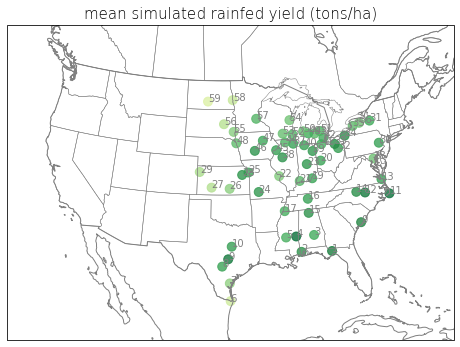

In [10]:
# Upscale yield from plant level (g/plant) to field level (tons/ha)
pop = 8  # plants/m2
ha_to_m2 = 10000
ton_to_g = 907185
ear_to_yield = 0.86  # only portion of ear converts into yield

# Visualize
fig = plt.figure(figsize=(8,6))
extent = [-123, -72, 19, 53]

ax = fig.add_subplot(1,1,1, projection=ccrs.AlbersEqualArea(
    central_latitude=39.5, central_longitude=-98.35))
crs = ccrs.PlateCarree()
transform = crs._as_mpl_transform(ax)

df_sub = df_matured.groupby('site').mean()
sim_yield = [(ha_to_m2*pop*ear*ear_to_yield)/ton_to_g for ear in df_sub.dm_ear]

ax.scatter(df_sub.lon, df_sub.lat, 
           c=sim_yield, 
           cmap=YlGn_9.mpl_colormap,
           transform=ccrs.PlateCarree(), alpha=0.8, s=80,
           vmin=5, vmax=14)

for site in np.arange(60):
    ax.annotate(site, (df_sub.lon[site], df_sub.lat[site]), 
                xycoords=transform, c='grey', size=10)

ax.set_extent(extent)
ax.add_feature(cfeature.COASTLINE, edgecolor='grey')
ax.add_feature(cfeature.BORDERS, edgecolor='grey')
ax.add_feature(cfeature.STATES, edgecolor='grey', linewidth=0.5)
ax.set_title('mean simulated rainfed yield (tons/ha)', fontsize=15, fontweight='light')

#plt.savefig('/home/disk/eos8/ach315/upscale/figs/map_yield_control_dympd.png', format='png', dpi=800)

Text(51.0, 0.5, 'sites')

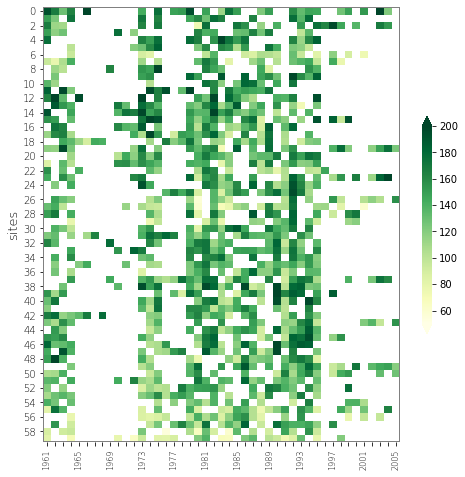

In [11]:
years = np.arange(1961, 2006)
sites = df_sites.site
df = df_matured.groupby(['site', 'year']).mean()
start_year = 1961

# Fetch yield data
mx = np.empty(shape=(len(sites), len(years)))
for count_site, site in enumerate(sites):
    ear_years = np.empty(len(years))
    ear_years[:] = np.nan

    for count_year, year in enumerate(years):
        try:
            ears = df.loc[(site, year)].dm_ear
        except(KeyError):
            ears = np.nan

        ear_years[count_year] = ears
        mx[count_site] = ear_years

# Customize xtick labels
array_xticks = ['']*45
index_array = np.arange(0,45,4)
array_years = np.arange(1961,2006,4)
for index_a, index_y in zip(index_array, range(len(array_years))):
    array_xticks[index_a] = array_years[index_y]

# Visualize     
fig = plt.figure(figsize=(8,8))    
ax = fig.add_subplot(1,1,1)
hm = sns.heatmap(mx, cmap=YlGn_9.mpl_colormap,
                 cbar_kws={'shrink': 0.5, 'extend': 'both'}, 
                 vmin=50, vmax=200)
hm.axhline(y = 0, color='grey',linewidth=2)
hm.axhline(y = mx.shape[0], color='grey', linewidth=2)
hm.axvline(x = 0, color='grey', linewidth=2)
hm.axvline(x = mx.shape[1], color='grey', linewidth=2)

plt.xticks(np.arange(0.5, 45.5, 1), fontweight='light', fontsize=11)
plt.yticks(fontweight='light', fontsize=10, rotation=0)
ax.set_xticklabels(array_xticks, fontsize=8, fontweight='light', rotation=90)
ax.set_ylabel('sites', fontweight='light', size=13)

#plt.savefig('/home/disk/eos8/ach315/upscale/figs/heatmap_yield_control_dympd.png', format='png', dpi=800)

[[]]

<Figure size 432x288 with 0 Axes>

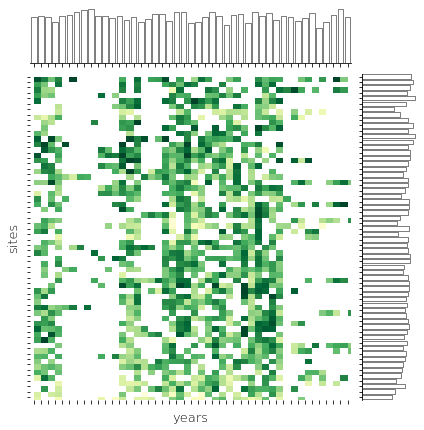

In [12]:
fig = plt.figure()

g = sns.JointGrid()
gmain = sns.heatmap(mx, cmap=YlGn_9.mpl_colormap,
                    cbar=False,
                    vmin=50, vmax=200,
                    ax=g.ax_joint)

gmain.set_xlabel('years', fontweight='light', size=13)
gmain.set_ylabel('sites', fontweight='light', size=13)

gx = sns.barplot(x = np.arange(45), y = pd.DataFrame(mx).mean(axis=0), 
            fill=False, linewidth=0.5, ax=g.ax_marg_x)
gx.set(xlabel=None)
gx.set(xticklabels=[])
gy = sns.barplot(x = pd.DataFrame(mx).mean(axis=1), y = np.arange(60),
                 orient = 'h', fill=False, linewidth=0.5, ax=g.ax_marg_y)
gy.set(xlabel=None)
gy.set(yticklabels=[])

#plt.savefig('/home/disk/eos8/ach315/upscale/figs/heatmap_yield_control_dympd_jointgrid.png', format='png', dpi=800)

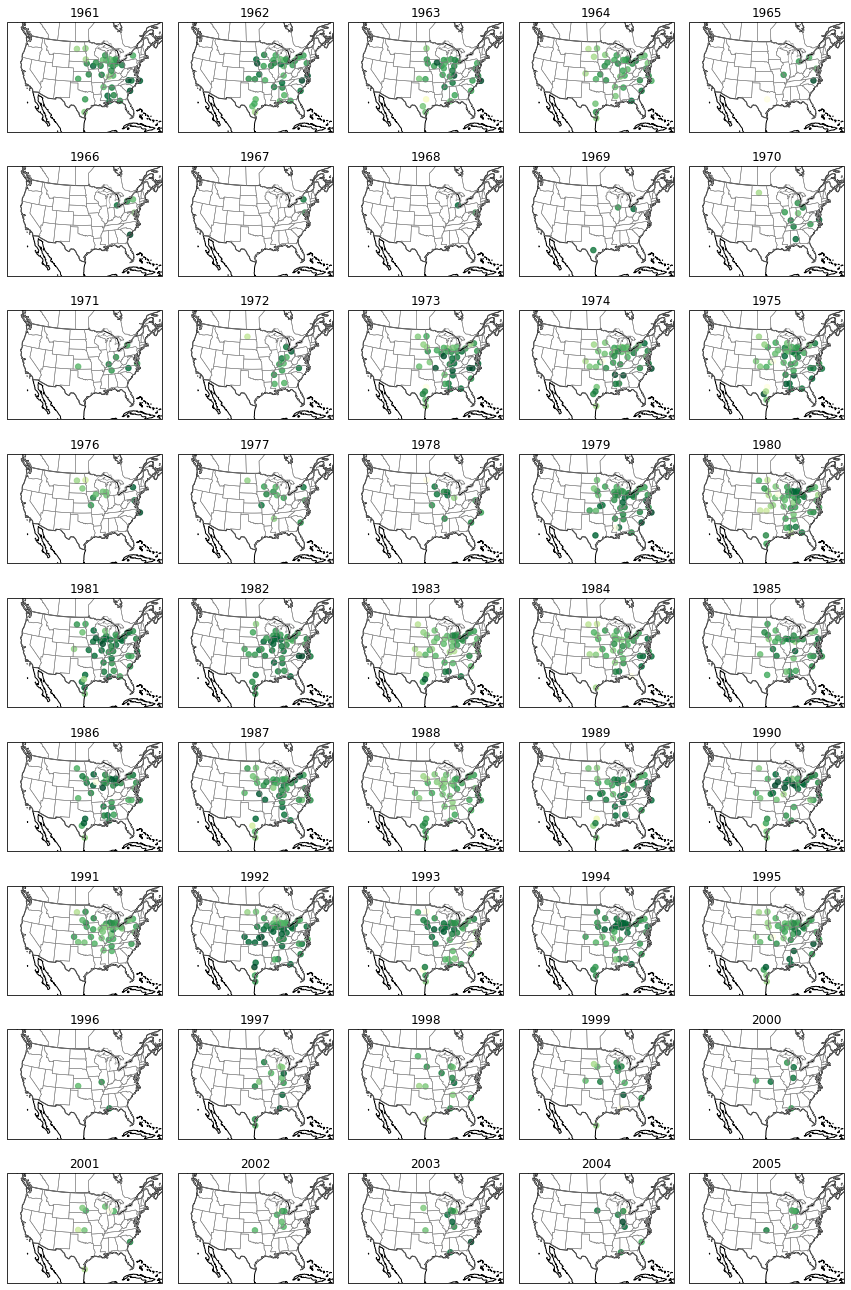

In [13]:
years = np.arange(1961, 2006)
extent = [-123, -72, 19, 53]

fig = plt.figure(figsize=(15,30))

for item, year in zip(np.arange(len(years)), years):
    ax = fig.add_subplot(9,5,item+1, projection=ccrs.AlbersEqualArea(
        central_latitude=39.5, central_longitude=-98.35))
    df_sub = df_all[df_all.year == year]
    ax.scatter(df_sub.lon, df_sub.lat, 
               c=df_sub.dm_ear, cmap=YlGn_9.mpl_colormap,
               transform=ccrs.PlateCarree(), alpha=0.8, s=30,
               vmin=0, vmax=200) 

    ax.set_extent(extent)
    ax.add_feature(cfeature.COASTLINE)
    ax.add_feature(cfeature.BORDERS)
    ax.add_feature(cfeature.STATES, edgecolor='grey', linewidth=0.5)
    ax.set(title=year)

fig.subplots_adjust(wspace=0.1, hspace=-0.7)

In [14]:
# Filters for year, planting area, & irrigation level
year_start = 2005
year_end = 2012
area = 10000/2.47  # acre into ha
irri = 10

# Filter NASS data
df_nass_summary = nass_summarize(year_start, year_end)
df_sub = df_nass_summary.query(f'(area > {area}) & (perct_irri < {irri})')

# Upscale yield from plant level (g/plant) to field level (tons/ha)
pop = 8 # plants/m2
ha_to_m2 = 10000
ton_to_g = 1000000  # metric ton
yield_conv = 0.86  # only portion of ear converts into yield

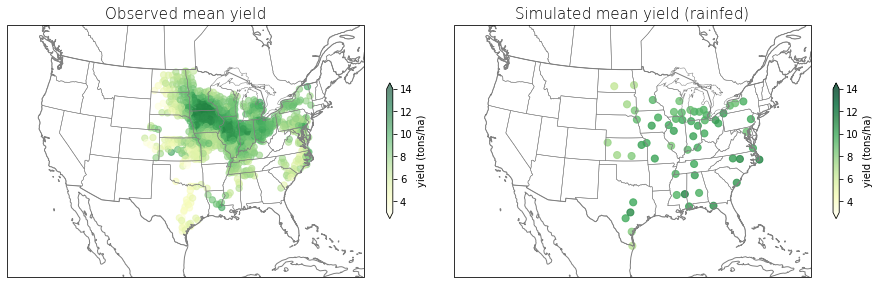

In [15]:
# Observed yield
fig = plt.figure(figsize=(16,5))
extent = [-123, -72, 19, 53]

ax1 = fig.add_subplot(1,2,1, projection=ccrs.AlbersEqualArea(
                     central_latitude=39.5, central_longitude=-98.35))

ax1.set_extent([-123,-72,19,53])
mp1 = ax1.scatter(df_sub.lon, df_sub.lat, 
                  transform=ccrs.PlateCarree(),
                  c=df_sub['yield'],
                  s=40,
                  cmap=YlGn_9.mpl_colormap,
                  vmin=3, vmax=14, alpha=0.6)

ax1.add_feature(cfeature.BORDERS, edgecolor='grey')
ax1.add_feature(cfeature.COASTLINE, edgecolor='grey')
ax1.add_feature(cfeature.STATES, edgecolor='grey', linewidth=0.5)
ax1.set_title('Observed mean yield', fontsize=15, fontweight='light')
fig.colorbar(mp1, shrink=0.5, label='yield (tons/ha)', extend='both')

# Sim yield
df_summary = df_matured.groupby('site').mean()
sim_yield = [(ha_to_m2*pop*ear*yield_conv)/ton_to_g for ear in df_summary.dm_ear]
#sim_area = [area/700 for area in df_summary['area']]

ax2 = fig.add_subplot(1,2,2, projection=ccrs.AlbersEqualArea(
    central_latitude=39.5, central_longitude=-98.35))

mp2 = ax2.scatter(df_summary.lon, df_summary.lat, 
                  transform=ccrs.PlateCarree(), 
                  c=sim_yield, 
                  cmap=YlGn_9.mpl_colormap,
                  alpha=0.8, vmin=3, vmax=14, s=50)
ax2.set_extent(extent)
ax2.add_feature(cfeature.COASTLINE, edgecolor='grey')
ax2.add_feature(cfeature.BORDERS, edgecolor='grey')
ax2.add_feature(cfeature.STATES, edgecolor='grey', linewidth=0.5)
ax2.set_title('Simulated mean yield (rainfed)', fontsize=15, fontweight='light')
fig.colorbar(mp2, shrink=0.5, label='yield (tons/ha)', extend='both')

fig.subplots_adjust(wspace=0, hspace=-0.8)

#plt.savefig('/home/disk/eos8/ach315/upscale/figs/validate_maps_0512.png', format='png', dpi=800)

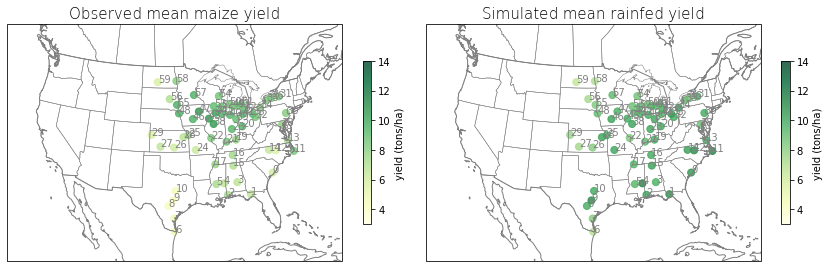

In [16]:
# Calculate average maize yield from NASS sites near sim sites
nass_yields = []

for item in np.arange(df_sites.shape[0]):
    lat = df_sites.iloc[item]['lat']
    lon = df_sites.iloc[item]['lon']
    
    dist = list(enumerate(
        np.sqrt((lat - df_sub.lat)**2 + (lon - (df_sub.lon))**2)))
    df_dist = pd.DataFrame(dist, columns=['rownum', 'distance'])
    rows = list(df_dist.nsmallest(10, 'distance').rownum)
    nass_yield = round(df_sub.iloc[rows]['yield'].mean(),2)
    nass_yields.append(nass_yield)
    

# Observed yield
fig = plt.figure(figsize=(15,6))
extent = [-123, -72, 19, 53]

ax1 = fig.add_subplot(1,2,1, projection=ccrs.AlbersEqualArea(
                     central_latitude=39.5, central_longitude=-98.35))
ax1.set_extent([-123,-72,19,53])
mp1 = ax1.scatter(df_sites.lon, df_sites.lat, 
                  transform=ccrs.PlateCarree(),
                  c=nass_yields,
                  cmap=YlGn_9.mpl_colormap,
                  alpha=0.8, vmin=3, vmax=14, s=50)

ax1.add_feature(cfeature.BORDERS, edgecolor='grey')
ax1.add_feature(cfeature.COASTLINE, edgecolor='grey')
ax1.add_feature(cfeature.STATES, edgecolor='grey', linewidth=0.5)
ax1.set_title('Observed mean maize yield', fontsize=15, fontweight='light')
crs = ccrs.PlateCarree()
transform = crs._as_mpl_transform(ax1)
for site in np.arange(60):
    ax1.annotate(site, (df_summary.lon[site], df_summary.lat[site]), 
                xycoords=transform, c='grey', size=10)

fig.colorbar(mp1, shrink=0.5, label='yield (tons/ha)')

# Sim yield
ax2 = fig.add_subplot(1,2,2, projection=ccrs.AlbersEqualArea(
    central_latitude=39.5, central_longitude=-98.35))
sim_yield = [(ha_to_m2*pop*ear*yield_conv)/ton_to_g for ear in df_summary.dm_ear]

mp2 = ax2.scatter(df_summary.lon, df_summary.lat, 
                  transform=ccrs.PlateCarree(), 
                  c=sim_yield, 
                  cmap=YlGn_9.mpl_colormap,
                  alpha=0.8, vmin=3, vmax=14, s=50)
ax2.set_extent(extent)
ax2.add_feature(cfeature.COASTLINE, edgecolor='grey')
ax2.add_feature(cfeature.BORDERS, edgecolor='grey')
ax2.add_feature(cfeature.STATES, edgecolor='grey', linewidth=0.5)
ax2.set_title('Simulated mean rainfed yield', fontsize=15, fontweight='light')

crs = ccrs.PlateCarree()
transform = crs._as_mpl_transform(ax2)
for site in np.arange(60):
    ax2.annotate(site, (df_summary.lon[site], df_summary.lat[site]), 
                xycoords=transform, c='grey', size=10)


fig.colorbar(mp2, shrink=0.5, label='yield (tons/ha)')

fig.subplots_adjust(wspace=0, hspace=-0.8)
#plt.savefig('/home/disk/eos8/ach315/upscale/figs/validate_map_sameloc_0512.png', format='png', dpi=800)

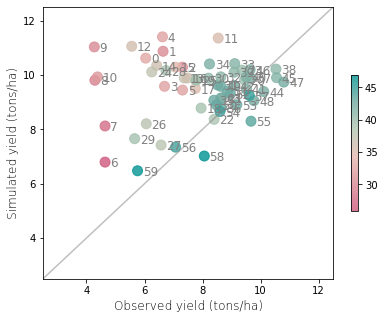

In [17]:
df_std = df_all.groupby('site').std()
df_count = df_all.groupby('site').count()
df_ste = df_std/np.sqrt(df_count)
sim_std = [(ha_to_m2*pop*ste*yield_conv)/ton_to_g for ste in df_ste.dm_ear]

# Visualization
fig = plt.figure(figsize=(6.5,5))
ax = fig.add_subplot(1,1,1)

plt.scatter(nass_yields, sim_yield, alpha=0.8,
            c = df_sites.lat, cmap = TealRose_6_r.mpl_colormap, s=100)
ax.set_xlim(2.5,12.5)
ax.set_ylim(2.5,12.5)

ax.axline((1, 1), slope=1, color='grey', alpha=0.5)

for site in np.arange(60):
    ax.annotate(site, (nass_yields[site]+0.18, sim_yield[site]-0.18), 
                c='grey', size=12)

plt.xlabel('Observed yield (tons/ha)', fontweight='light', fontsize=12)
plt.ylabel('Simulated yield (tons/ha)', fontweight='light', fontsize=12)
plt.colorbar(shrink=0.5)

#plt.savefig('/home/disk/eos8/ach315/upscale/figs/validate_scatter_0512.png', format='png', dpi=800)

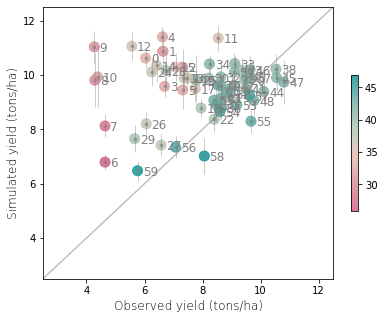

In [18]:
df_std = df_all.groupby('site').std()
df_count = df_all.groupby('site').count()
df_ste = df_std/np.sqrt(df_count)
sim_std = [(ha_to_m2*pop*ste*yield_conv)/ton_to_g for ste in df_ste.dm_ear]

# Visualization
fig = plt.figure(figsize=(6.5,5))
ax = fig.add_subplot(1,1,1)

plt.scatter(nass_yields, sim_yield, alpha=0.8,
            c = df_sites.lat, cmap = TealRose_6_r.mpl_colormap, s=100)
plt.errorbar(nass_yields, sim_yield, yerr=sim_std, 
             fmt='.', alpha=0.5, color='grey', linewidth=0.8)
ax.set_xlim(2.5,12.5)
ax.set_ylim(2.5,12.5)

ax.axline((1, 1), slope=1, color='grey', alpha=0.5)

for site in np.arange(60):
    ax.annotate(site, (nass_yields[site]+0.18, sim_yield[site]-0.18), 
                c='grey', size=12)

plt.xlabel('Observed yield (tons/ha)', fontweight='light', fontsize=12)
plt.ylabel('Simulated yield (tons/ha)', fontweight='light', fontsize=12)
plt.colorbar(shrink=0.5)

#plt.savefig('/home/disk/eos8/ach315/upscale/figs/validate_scatter_0512_errbar.png', format='png', dpi=800)